In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import onnxruntime as ort
import utils
from util_onnx import onnx_export
import utils
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "6,7"
import gc
gc.collect()

0

In [10]:
import os
import torch
import torch.nn as nn
from diffusers.schedulers import PNDMScheduler
from pathlib import Path
from diffusers import DiffusionPipeline
device = 'cpu'
dtype = torch.float32
save_path = '../onnx_models_cuda'
os.makedirs(save_path, exist_ok = True)

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32).to(device)

In [2]:
save_path = '../onnx_models_cuda'

In [5]:
def load_session(path, provider = 'cuda'):
    if provider == 'cuda':
        return ort.InferenceSession(path, providers=['AzureExecutionProvider'])
    else:
        return ort.InferenceSession(path)

In [6]:
sessTokenizer       = load_session(f'{save_path}/tokenizer/to_quant.onnx', 'cpu')
sessionTextEncoder  = load_session(f'{save_path}/text_encoder/te_quant.onnx', 'cpu')

In [9]:
ascii_str   = utils.toAsciiTensor()
text_ids = sessTokenizer.run(None, {
    'input' : ascii_str.detach().cpu().numpy()
})[0]
embed = sessionTextEncoder.run(None, {
    'input' : text_ids
})[0]
print(text_ids.shape)
print(text_ids)
print(embed.shape)

(1, 77)
[[49407   320  3490  2368 49406     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]
(2, 77, 768)


In [11]:
latents0 = torch.randn([1,4,64,64], dtype= dtype, device =device)

In [12]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
timesteps
latents = latents0.clone()
extra_step_kwargs = {}
for i, t in enumerate(timesteps):
    latent_model_input = torch.cat([latents] * 2).to(device = device)
    latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t).to(device = device)
    # predict the noise residual
    noise_pred = pipeline.unet(
        latent_model_input.to(device = device),
        t,
        encoder_hidden_states=torch.tensor(embed).to(device = device),
        cross_attention_kwargs=None,
        return_dict=False,
    )[0]
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
    latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    print(t, end=' -> ' if (i%10 != 0 and i!= 0) else ' -> \n')

981 -> 
961 -> 961 -> 941 -> 921 -> 901 -> 881 -> 861 -> 841 -> 821 -> 801 -> 
781 -> 761 -> 741 -> 721 -> 701 -> 681 -> 661 -> 641 -> 621 -> 601 -> 
581 -> 561 -> 541 -> 521 -> 501 -> 481 -> 461 -> 441 -> 421 -> 401 -> 
381 -> 361 -> 341 -> 321 -> 301 -> 281 -> 261 -> 241 -> 221 -> 201 -> 
181 -> 161 -> 141 -> 121 -> 101 -> 81 -> 61 -> 41 -> 21 -> 1 -> 


In [27]:
vae_decoder = pipeline.vae
vae_decoder.forward = vae_decoder.decode

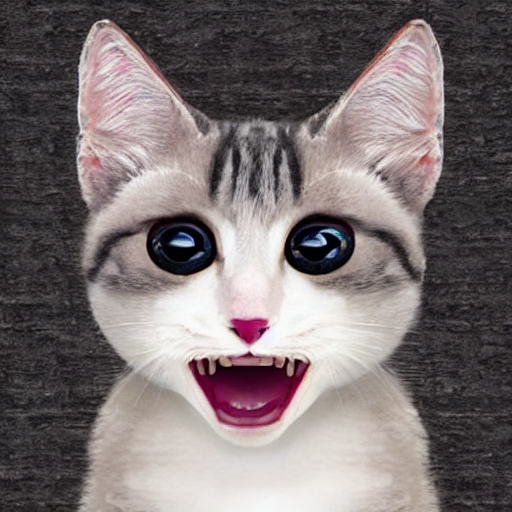

In [39]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

image = (1 / 0.18215 * latents)#.detach().numpy()
image = torch.concat(
    [vae_decoder(image[i : i + 1])[0] for i in range(image.shape[0])]
)
image = torch.clip(image / 2 + 0.5, 0, 1)
image = image.permute(0, 2, 3, 1)
image = numpy_to_pil(image.detach().numpy())
image[0].show()

In [40]:
np.save('./latenst_original.npy', latents0)